# LSTM Forecasting model
**Objective:**We want to forecast future values for feature **B.RTD1**.

**Data set:** RICO1_Dataset.hdf

  - **Description:** .....


**Features:**

Index| Features|Format|Description
-----|---------------|-------------------|-----------------------
1|_time|01.01.2009 00:10:00+00:00|Date-time reference
2|B.ASTRHT2.H|25.400000|Relative humidity of the ventilation air
3|B.ASTRHT2.S|25.400000|Air speed
4|B.ASTRHT2.T|25.4|Temperature
5|B.RTD1|25.400000|Thermometer centre of the room 10 cm from the floor
6|B.RTD2|25.45|Thermometer centre of the room 60 cm from the floor
7|B.RTD3|25.30|Thermometer centre of the room 100 cm from the floor
8|B.RTD6|25.30|Glober thermometer 160 from the floor
9-13|BT.AOC|XXX|Thermocouple in air above the outer cell wall (C: ceiling, F: floor, N,W,E : North, West, East)
14-16|BT.SIC_2X|XXX|Thermocouple on the internal cell, celing 25,26,27 respectively 70cm from the door, middle of the room, 70 cm from the window.
17-19|BT.SIE_7|XXX|Thermocouple on the internal cell, east wall  7,8,9 same as SIC. 10 middle of the room below the ceiling 11 above the floor.
20-22|BT.SIF_25|XXX|Thermocouple on the internal cell, floor 25,26,27 respectively 70cm from the door, middle of the room, 70 cm from the window.
23|BT.SIN_17|XXX|Thermocouple on the internal cell beside the door.
24-26|BT.SIW_X|XXX|Thermocouple on the internal cell, west wall  7,8,9 same as SIC. 10 middle of the room below the ceiling 11 above the floor.
25-29|BT.SOX|XXX|Thermocouple on the sheilded surface of the the outer cell wall (C: ceiling, F: floor, N,W,E : North, West, East)
26|EC3|XXXX|Electrical heater
27|JP40_head|XXXX|Head value for main cold water pump
28|JP40_setpoint|XXXX|Set point for main cold water pump
29|JP40_volumeFlow|XXXX|Volume flow in main cold water pump
30|JP410_head|XXXX|Head value for hot water pump in cell B
31|JP410_setpoint|XXXX|Set point for hot water pump in cell B
32|JP410_volumeFlow|XXXX|Volume flow for hot water pump in cell B
33|JP41_head|XXXX|Head value for main hot water pump
34|JP41_setpoint|XXXX|Set point for main hot water pump
35|JP41_volumeFlow|XXXX|Volume flow in main hot water pump
37|JP44_head|XXXX|Head value for cold water pump in ventilation duct
38|JP44_setpoint|XXXX|Set point for cold water pump in ventilation duct
39|JP44_volumeFlow|XXXX|Volume flow for cold water pump in ventilation duct
40|JP49_head|XXXX|Head value for cold water pump in cell B
41|JP49_setpoint|XXXX|Set point for cold water pump in cell B
42|JP49_volumeFlow|XXXX|Volume flow for cold water pump in cell B
43|JV41|XXXX|EMPTY**
44|JV42|XXXX|EMPTY**
45|JV51|XXXX|EMPTY**
47|RTD406A|XXXX|Ventilation heating/cooling downstream
48|RTD410.T|XXXX|Ventilation heating/cooling upstream
49|RTD417|XXXX|Fan coil temperature of cold water circuit in cell B (inlet)
50|RTD420|XXXX|Temperature of hot water circuit in cell B on the radiator heating (inlet)
51|RTD508|XXXX|Fan coil temperature of cold water circuit in cell B (outlet)
52|RTD509|XXXX|Temperature of hot water circuit in cell B on the radiator heating (outlet)
53|SB43|XXXX|Control for ventilation cooling
54|SB46|XXXX|Control for fan coil
55|SB47|XXXX|Control for the radiator heating
57|SSR06|XXXX|Switch of the fancoil fan
58-65|WS1_XXXX|XXXX|Features measured by the weather station
66|O.SIM1|XXXX|Solar radiation on the roof slope
67|O.SIM2|XXXX|Solar radiation on the vertical plane
68|O.SIM3|XXXX|Solar radiation impinging the facade
69-72|PID/XXX.setpoint|XXXX|Set point PID for each type of feature out of EC3, SB46, SB43, SB47***
73-76|PID/XXX.enabled|XXXX| Enabled or not PID for each type of feature out of EC3, SB46, SB43, SB47***




This project is divided into two main parts:
1. Forecast on past values
2. Forecast including other feature values

The following code snippet applies to and is necessary for all code that will follow:

In [ ]:
# Imports'
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.layers import *
from tensorflow import keras
from datetime import datetime
from google.colab import drive
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.feature_selection import mutual_info_regression

# Mounting drive and declaration of path for images
drive.mount('/content/drive', force_remount=True)
save_path = '/content/drive/My Drive/TFG_Images'
log_path = '/content/drive/My Drive/TFG_models/training_log.xlsx'

def build_lstm_model(input_shape, lstm_layers, dense_layers, lstm_units, dense_units,
                     activation='relu', dropout_rate=0.0, batch_normalization=False,
                     compile_model=True):
    """
    Build an LSTM model based on the provided configuration.
    :param input_shape: Shape of the input data (tuple).
    :param lstm_layers: Number of LSTM layers (list of booleans indicating return_sequences).
    :param dense_layers: Number of Dense layers.
    :param lstm_units: Number of units in each LSTM layer (list of integers).
    :param dense_units: Number of units in each Dense layer (list of integers).
    :param activation: Activation function for LSTM and Dense layers.
    :param dropout_rate: Dropout rate for Dropout layers.
    :param batch_normalization: Whether to use Batch Normalization.
    :return: Keras model.
    """

    model = Sequential()
    model.add(InputLayer(input_shape))

    # Adding LSTM layers
    for i, units in enumerate(lstm_units):
        return_sequences = lstm_layers[i] if i < len(lstm_layers) else False
        model.add(LSTM(units, activation=activation, return_sequences=return_sequences))
        if batch_normalization:
            model.add(BatchNormalization())
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    # Adding Dense layers
    for units in dense_units:
        model.add(Dense(units, activation=activation))

    return model

def plot_loss(phase, model_n, hist):
  plt.plot(hist.history['loss'], label='Training Loss')
  plt.plot(hist.history['val_loss'], label='Validation Loss')
  plt.title(f'[{phase}] Model {model_n} -  Loss plot')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(loc='best')
  # Save the figure
  time = datetime.now().strftime('%d_%H%M')
  plt.savefig(os.path.join(save_path, f'{phase}_Model{model_n}_Loss_Plot_{time}.jpeg'))
  print(f'{phase} - Model {model_n} loss plot saved!')
  plt.show()
  plt.close()

def fit_model(model, data, param_config, callback, val_split=None, model_n=None, val_data=None):
  if val_split != None:
    hist = model.fit(data[0],data[1], validation_split=val_split, epochs=param_config['epochs'], batch_size=param_config['batch_size'], callbacks=[callback])
    #data[0]:X_train, [1]:y_train
    if model.summary == model1.summary:
      plot_loss(1,'1',hist)
    elif model.summary == model2.summary:
      plot_loss(1,'2',hist)
  # Approach for phase 2 has validation data rather than validation split
  else:
    hist = model.fit(data[0],data[1], validation_data=val_data, epochs=param_config['epochs'], batch_size=param_config['batch_size'], callbacks=[callback])
    if model.summary == modelO.summary:
      plot_loss(3,'Opt',hist)
    elif model.summary == modelA.summary:
      plot_loss(1,'A',hist)
    elif model.summary == modelB.summary:
      plot_loss(2,'B',hist)
    elif model.summary == modelC.summary:
      plot_loss(2,'B',hist)


def plot_prediction(df, train_result, phase, model_n):
  # Plot the prediction loss
  plt.plot(train_result['Predictions'], label='Prediction')
  plt.plot(train_result['Actuals'], label='Original')
  plt.title(f'[{phase}] Model {model_n} -  Prediction plot')
  plt.xlabel('Time')
  plt.ylabel('Temperature (C)')
  plt.legend(loc='best')

  # Save the figure
  time = datetime.now().strftime('%d_%H%M')
  plt.savefig(os.path.join(save_path, f'{phase}_Model{model_n}_Prediction_Plot_{time}FUNC.jpeg'))
  print(f'{phase} - Model {model_n} prediction plot saved!')

  plt.show()
  plt.close()

def predicting(df, model, X_train, y_train):
  train_pred = model.predict(X_train)

  if train_pred.ndim == 2 and train_pred.shape[1] != y_train.shape[1]:
        print(f"{train_pred.ndim}\n {train_pred.shape[1]}\n{y_train.shape[1]} \n Reshaping train_pred to match y_train's second dimension")
        train_pred = train_pred.reshape(-1, y_train.shape[1])


  train_pred = train_pred.flatten()
  y_train = y_train.flatten()

  # Ensure that train_pred and y_train have the same length
  min_length = min(len(train_pred), len(y_train))
  train_pred = train_pred[:min_length]
  y_train = y_train[:min_length]

  train_result = pd.DataFrame(data={'Predictions':train_pred, 'Actuals': y_train} )
  train_result[['Predictions', 'Actuals']] = scaler.inverse_transform(train_result[['Predictions', 'Actuals']])

  # Plotting predictions
  if model.summary == model1.summary:
    plot_prediction(df, train_result, 1,'1')
  elif model.summary == model2.summary:
    plot_prediction(df, train_result, 1,'2')
  elif model.summary == modelO.summary:
      plot_prediction(df, train_result, 3,'Opt')
  elif model.summary == modelA.summary:
    plot_prediction(df, train_result, 2,'A')
  elif model.summary == modelB.summary:
    plot_prediction(df, train_result, 2,'B')
  elif model.summary == modelC.summary:
    plot_prediction(df, train_result, 2,'C')


  return train_result

def evaluation(model, train_result, data):
  scores = model.evaluate(data[0], data[1]) #data[0]:X_test, [1]:y_test
  mse = mean_squared_error(train_result['Actuals'], train_result['Predictions'])

  if model.summary == model1.summary:
    print(f'Model 1 Results: \n Loss: {scores} \n MSE : {mse}')
  elif model.summary == model2.summary:
    print(f'Model 2 Results: \n Loss: {scores} \n MSE : {mse}')
  elif model.summary == modelO.summary:
    print(f'Model C Results: \n Loss: {scores} \n MSE : {mse}')
  elif model.summary == modelA.summary:
    print(f'Model A Results: \n Loss: {scores} \n MSE : {mse}')
  elif model.summary == modelB.summary:
    print(f'Model B Results: \n Loss: {scores} \n MSE : {mse}')
  elif model.summary == modelC.summary:
    print(f'Model C Results: \n Loss: {scores} \n MSE : {mse}')


  return scores, mse


Mounted at /content/drive


# 1. Forecasting on past values

## 1.1 Initial data preparation

We have decided to assemble data in intervals of 10 minutes using their mean as global value.

In [ ]:
# 1. Reading dataset
df = pd.read_hdf('/content/drive/My Drive/TFG_models/RICO1_Dataset.hdf', key='all')

# _time as index
df['_time'] = pd.to_datetime(df['_time'])
df.set_index('_time', inplace=True)

# 2. Assembling data in 10 min intervals
df = df.resample('10T').mean()
df.index


DatetimeIndex(['2023-07-26 11:00:00+00:00', '2023-07-26 11:10:00+00:00',
               '2023-07-26 11:20:00+00:00', '2023-07-26 11:30:00+00:00',
               '2023-07-26 11:40:00+00:00', '2023-07-26 11:50:00+00:00',
               '2023-07-26 12:00:00+00:00', '2023-07-26 12:10:00+00:00',
               '2023-07-26 12:20:00+00:00', '2023-07-26 12:30:00+00:00',
               ...
               '2023-08-12 09:30:00+00:00', '2023-08-12 09:40:00+00:00',
               '2023-08-12 09:50:00+00:00', '2023-08-12 10:00:00+00:00',
               '2023-08-12 10:10:00+00:00', '2023-08-12 10:20:00+00:00',
               '2023-08-12 10:30:00+00:00', '2023-08-12 10:40:00+00:00',
               '2023-08-12 10:50:00+00:00', '2023-08-12 11:00:00+00:00'],
              dtype='datetime64[ns, tzutc()]', name='_time', length=2449, freq='10T')

## 1.2 Data prepreprocessing
This process is crucial in forecasting models as LSTMs. It has a great influence on the model's performance. This section involves:
1. Scaling
2. Spliting data

### 1.2.1 Scaling data
We are implementing the MinMaxScaler as we are only dealing with 1 feature and therefore we don't have to look out for non-linear relationships between variables.
Scaling the data will help us to ensure that there is no ..(?)..

In [ ]:
scaler = MinMaxScaler()
temp = df['B.RTD1'].values.reshape(-1, 1)
scaled_temp = scaler.fit_transform(temp)
scaled_temp = pd.DataFrame(scaled_temp) # len=2449

### 1.2.2 Spliting data into train and split

In [ ]:
def df_to_X_y(df, window_size, forecast_horizon):
    """
    Convert a DataFrame into X and y arrays for time series forecasting.

    :param df: DataFrame containing the time series data.
    :param window_size: Number of past observations to use for forecasting.
    :param forecast_horizon: Number of future observations to forecast.
    :return: Tuple of numpy arrays (X, y), where X is the feature set and y is the target set.
    """
    df_as_np = df.to_numpy()
    X = []
    y = []

    for i in range(len(df_as_np) - window_size - forecast_horizon + 1):
        row = [[a] for a in df_as_np[i:i + window_size]]
        X.append(row)

        # Now, instead of adding a single value to y, add a range of values
        label = df_as_np[i + window_size:i + window_size + forecast_horizon]
        y.append(label)

    X = np.array(X)
    y = np.array(y)

    # Reshaping X to remove the unnecessary last dimension
    if X.shape[-1] == 1:
        X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

    return X, y

window_size = 24
forecast_horizon = 5

X, y = df_to_X_y(scaled_temp, window_size, forecast_horizon)

X_train, y_train = X[:int(len(X) * 0.8)], y[:int(len(y) * 0.8)]
X_test, y_test = X[int(len(X) * 0.8):], y[int(len(y) * 0.8):]

# X: (samples, window_size, features) // y: (samples, forecast_horizon, features)
input_shape = (X_train.shape[1], X_train.shape[2])
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((1936, 24, 1), (1936, 5, 1), (485, 24, 1), (485, 5, 1))

## 1.3 Building, training, predicting and evaluating LSTM model

In this part, we will experiment with different kinds of:
  - model architectures,
  - learning rates,
  - dropout rates,
  - activation functions,
  - number of epochs and,
  - batch sizes

as well as other hyperparameters to obtain the best possible forecasts.

### 1.3.1 Model 1

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 64)                16896     
                                                                 
 dense_54 (Dense)            (None, 10)                650       
                                                                 
 dense_55 (Dense)            (None, 5)                 55        
                                                                 
Total params: 17601 (68.75 KB)
Trainable params: 17601 (68.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/8
65/65 [==============================] - 4s 45ms/step - loss: 0.0805 - val_loss: 0.0086
Epoch 2/8
65/65 [==============================] - 3s 40ms/step - loss: 0.0058 - val_loss: 0.0015
Epoch 3/8
65/65 [==============================] - 1s 14ms/step - loss: 0.0039 - val_

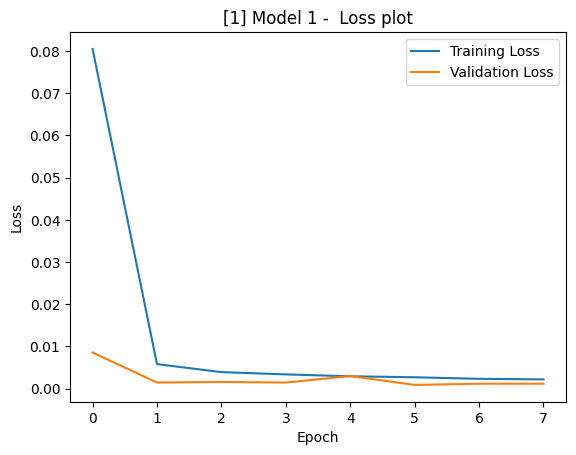

61/61 [==============================] - 0s 5ms/step
1 - Model 1 prediction plot saved!


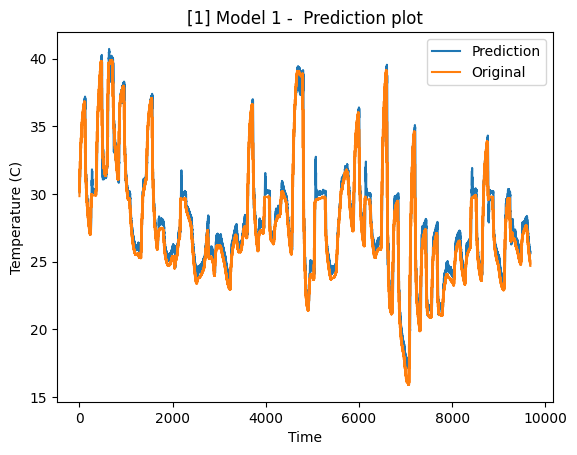

16/16 [==============================] - 0s 5ms/step - loss: 0.0012
Model 1 Results: 
 Loss: 0.0012102455366402864 
 MSE : 1.0216395586245173


In [ ]:
# Definition for model1
lstm_layers_model1 = [False]
lstm_units_model1 = [64]
dense_layers_model1 = 2
dense_units_model1 = [10,5]


# Building model1
model1 = build_lstm_model(input_shape, lstm_layers_model1, dense_layers_model1,
                          lstm_units_model1, dense_units_model1)

model1.summary()

# Training configuration
config1 = {
    'batch_size': 24,
    'epochs': 8,
    'learning_rate': 0.015
}

# Compile
model1.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=config1['learning_rate']))

cp1_1 = ModelCheckpoint('/content/drive/My Drive/TFG_models/1_model1/', save_best_only=True) # lowest val_loss

# Training model 1
fit_model(model1, (X_train,y_train), config1, cp1_1, 0.2)

# Predicting on model 1
train_result = predicting(df, model1, X_train, y_train , cp1_1)

# Evaluating prediction
scores1, mse1 = evaluation(model1, train_result, (X_test,y_test))

### 1.3.2 Model 2

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 24, 64)            16896     
                                                                 
 batch_normalization_12 (Ba  (None, 24, 64)            256       
 tchNormalization)                                               
                                                                 
 dropout_12 (Dropout)        (None, 24, 64)            0         
                                                                 
 lstm_35 (LSTM)              (None, 32)                12416     
                                                                 
 batch_normalization_13 (Ba  (None, 32)                128       
 tchNormalization)                                               
                                                                 
 dropout_13 (Dropout)        (None, 32)              

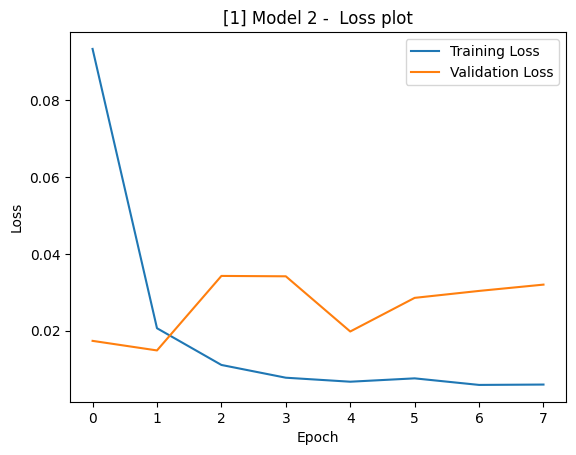

61/61 [==============================] - 1s 8ms/step
1 - Model 2 prediction plot saved!


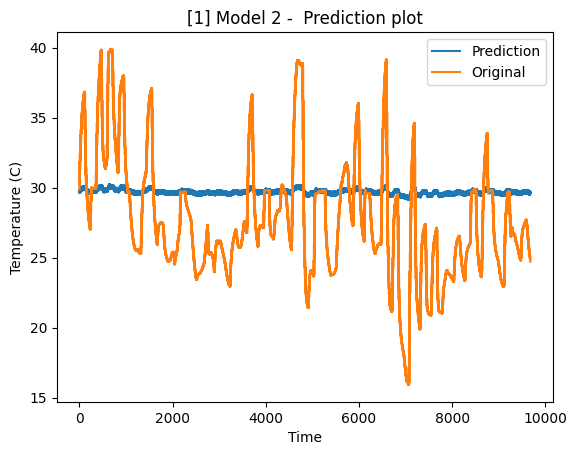

16/16 [==============================] - 0s 9ms/step - loss: 0.0391
Model 2 Results: 
 Loss: 0.0391237698495388 
 MSE : 21.939552088824712


In [ ]:
# Definition for model2
lstm_layers_model2 = [True, False]
lstm_units_model2 = [64, 32]
dense_layers_model2 = 2
dense_units_model2 = [15,5]

# Building model2
model2 = build_lstm_model(input_shape, lstm_layers_model2, dense_layers_model2,
                          lstm_units_model2, dense_units_model2, dropout_rate=0.2,
                          batch_normalization=True)
model2.summary()

# Training configuration
config2 = {
    'batch_size': 60,
    'epochs': 8,
    'learning_rate': 0.01
}

model2.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=config2['learning_rate']))

cp2_1 = ModelCheckpoint('/content/drive/My Drive/TFG_models/1_model2/', save_best_only=True)

fit_model(model2, (X_train,y_train), config2, cp2_1, 0.2)
train_result = predicting(df, model2, X_train, y_train , cp2_1)
scores2, mse2 = evaluation(model2, train_result, (X_test,y_test))


### 1.3.3 Saving all results

In [ ]:
import openpyxl
for model_n, model in enumerate([model1,model2,modelA,modelB,modelC], start=1):
    if model_n == 1:
      # Get the last loss and MSE
      loss = scores1
      mse = mse1  # Replace 'mse' with your actual MSE metric key if different
      config=config1
    elif model_n == 2:
      loss = scores2
      mse = mse2  # Replace 'mse' with your actual MSE metric key if different
      config=config2

    # Get the model summary as a string
    summary = []
    model.summary(print_fn=lambda x: summary.append(x))
    summary_str = "\n".join(summary)

    # Create a DataFrame with the results
    time_str = datetime.now().strftime('%Y%m%d%H%M%S')  # Fixed the format to include year and seconds
    results_df = pd.DataFrame({
        'Model': f"{model_n}_{time_str}",
        'Summary of the architecture (string)': summary_str,
        'learning_rate': config['learning_rate'],
        'epoch': config['epochs'],
        'batch_size': config['batch_size'],
        'Loss': loss,
        'MSE': mse
    }, index=[0])

    file_exists = os.path.isfile(log_path)

    # Write the DataFrame to the Excel file
    if not file_exists:
        with pd.ExcelWriter(log_path, engine='openpyxl') as writer:
            results_df.to_excel(writer, index=False)
        file_exists = True  # Update the flag so headers are not added again
    else:
        with pd.ExcelWriter(log_path, mode='a', if_sheet_exists='overlay', engine='openpyxl') as writer:
            results_df.to_excel(writer, index=False, header=False, startrow=writer.sheets['Sheet1'].max_row)

## Hyperparameter tuning


In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.6 MB/s eta 0:00:00


In [ ]:
import kerastuner as kt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   return_sequences=True,
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))

    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(LSTM(units=hp.Int(f'lstm_{i}_units',
                                    min_value=32,
                                    max_value=512,
                                    step=32),
                       return_sequences=True))
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(LSTM(units=hp.Int('final_lstm_units', min_value=32, max_value=512, step=32), return_sequences=False))
    model.add(Dropout(hp.Float('final_dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(units=1, activation='linear'))

    model.compile(optimizer='adam', loss='mse', metrics=['mse'])

    return model

tuner = kt.Hyperband(build_model,
                     objective='val_mse',
                     max_epochs=40,
                     hyperband_iterations=2,
                     directory='my_dir',
                     project_name='final_lstm_tuning')

stop_early = EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train, epochs=40, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)
model.fit(X_train, y_train, epochs=20, validation_split=0.2)

# Evaluate the model
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {test_accuracy}')

ModuleNotFoundError: ignored

# 2. Forecasting including other feature values
  To do this, we have to study which of the other 78 features are mostly relevant to feature **B.RTD1**. This task will be performed using the _Mutual Information Score_

  **a. Mutual Information Score:**

  - Why? It can capture any kind of realtionship, not just linearity
  - Interpretation:
    - High: More informative about target variable
    - Low: Less informative about target variable

## 2.1 Initial data preparation

In [ ]:
# 1. Reading data set and prepping it again
df = pd.read_hdf('/content/drive/My Drive/TFG_models/RICO1_Dataset.hdf', key='all')
df['_time'] = pd.to_datetime(df['_time'])
df.set_index('_time', inplace=True)

df = df.resample('10T').mean()
df

,B.ASTRHT2.H,B.ASTRHT2.S,B.ASTRHT2.T,B.RTD1,B.RTD2,B.RTD3,B.RTD6,BT.AOC,BT.AOE,BT.AOF,...,O.SIM2,O.SIM3,PID/SB47.setpoint,PID/SB46.setpoint,PID/EC3.setpoint,PID/SB43.setpoint,PID/SB47.enabled,PID/SB46.enabled,PID/EC3.enabled,PID/SB43.enabled
_time,,,,,,,,,,,,,,,,,,,,,
2023-07-26 11:00:00+00:00,25.537037,1.138889,33.448148,25.696296,26.229630,26.342593,27.412963,26.014815,26.238889,25.609259,...,181.000000,164.629630,20.0,7.0,30.0,0.0,1.0,1.0,1.0,0.0
2023-07-26 11:10:00+00:00,20.816667,1.743333,36.718333,26.268333,27.125000,27.306667,29.433333,26.143333,26.350000,25.751667,...,145.700000,124.716667,20.0,7.0,30.0,0.0,1.0,1.0,1.0,0.0
2023-07-26 11:20:00+00:00,25.416667,1.791667,33.535000,27.171667,28.305000,28.430000,30.403333,26.250000,26.453333,25.803333,...,133.200000,113.866667,20.0,7.0,30.0,0.0,1.0,1.0,1.0,0.0
2023-07-26 11:30:00+00:00,29.700000,1.741667,31.000000,28.046667,29.108333,29.306667,30.431667,26.301667,26.500000,25.881667,...,125.316667,106.566667,20.0,7.0,30.0,0.0,1.0,1.0,1.0,0.0
2023-07-26 11:40:00+00:00,31.933333,1.750000,29.623333,28.756667,29.461667,29.741667,30.125000,26.300000,26.568333,25.900000,...,110.500000,89.700000,20.0,7.0,30.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-12 10:20:00+00:00,53.216667,2.881667,22.371667,24.630000,24.751667,24.726667,25.038333,26.378333,26.900000,26.700000,...,216.366667,167.216667,40.0,7.0,20.0,0.0,1.0,1.0,1.0,0.0
2023-08-12 10:30:00+00:00,53.116667,2.900000,22.400000,24.755000,24.875000,24.850000,25.266667,26.393333,26.906667,26.700000,...,320.533333,272.066667,40.0,7.0,20.0,0.0,1.0,1.0,1.0,0.0
2023-08-12 10:40:00+00:00,53.233333,2.870000,22.521667,24.993333,25.096667,25.043333,25.665000,26.340000,26.963333,26.700000,...,552.866667,506.683333,40.0,7.0,20.0,0.0,1.0,1.0,1.0,0.0


## 2.2. Data preprocessing
Including:
- correlations regarding B.RTD1
- spliting data before normalisation to avoid data leakage
- scaling / normalising data
- create a dataset suitable for LSTM training

Feature Information saved!


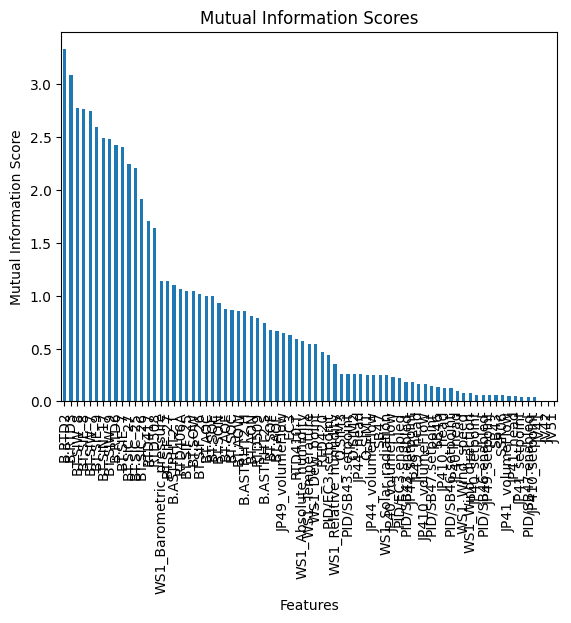

Index(['B.RTD2', 'B.RTD3', 'BT.SIW_8', 'BT.SIE_8', 'BT.SIW_7'], dtype='object')


In [ ]:
def most_useful_features():
  # Calculate mutual information scores
  mi_scores = mutual_info_regression(X, y)

  # Create a Series to visualize the scores
  mi_scores_series = pd.Series(mi_scores, index=X.columns)

  # Sort the scores
  mi_scores_series = mi_scores_series.sort_values(ascending=False)

  # Plotting
  mi_scores_series.plot(kind='bar')
  plt.title('Mutual Information Scores')
  plt.ylabel('Mutual Information Score')
  plt.xlabel('Features')

  # Save the figure
  plt.savefig(os.path.join(save_path, f'Feature_Information.jpeg'))
  print(f'Feature Information saved!')

  plt.show()
  plt.close()

  return mi_scores_series

top_scores = most_useful_features()

# Select top N features based on mutual information scores
top_n_features = top_scores.head(5).index

# Subset your features based on the selection
X_selected = X[top_n_features]
print(top_n_features)

### 2.2.1 Splitting train and target data

In [ ]:
X = df.drop(['B.RTD1'], axis=1)
y = df['B.RTD1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

### 2.2.2 Scaling / Normalising data

In [ ]:
scaler_x = RobustScaler()
scaler_y = RobustScaler()

X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

### 2.2.3 Suitable dataset

In [ ]:
# Function to create a dataset suitable for LSTM training
def create_dataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps), :]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Define the time_steps (look_back)
time_steps = 20

# Prepare the input X and the output y for the LSTM model
X_train_seq, y_train_seq = create_dataset(X_train_scaled, y_train_scaled.flatten(), time_steps)
X_test_seq, y_test_seq = create_dataset(X_test_scaled, y_test_scaled.flatten(), time_steps)


(1939,)

## 2.3 Building, training, predicting and evaluating LSTM model

### 2.3.1 Model A

#### Model A - Building

In this part, we will experiment with different kinds of:
  - model architectures,
  - learning rates,
  - dropout rates,
  - activation functions,
  - number of epochs and,
  - batch sizes

as well as other hyperparameters to obtain the best possible forecasts.

In [ ]:
modelA = Sequential()
modelA.add(LSTM(50, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
modelA.add(Dense(1))
modelA.compile(optimizer=Adam(learning_rate=0.01), loss=MeanSquaredError())
#model1.summary()

# Training configuration
configA = {
    'batch_size': 64,
    'epochs': 25,
    'learning_rate': 0.01
}

# Compile
modelA.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=configA['learning_rate']))

cpA = ModelCheckpoint('/content/drive/My Drive/TFG_models/modelA/', save_best_only=True) # lowest val_loss

fit_model(modelA, (X_train,y_train), configA, cpA, val_data=(X_test_seq,y_test_seq))
train_result = predicting(df, modelA, X_train, y_train , cpA)
scoresA, mseA = evaluation(modelA, train_result, (X_test,y_test))

#### Model A - Training

In [ ]:
histA = modelA.fit(X_train,y_train, validation_split=0.2, epochs=configA['epochs'], batch_size=configA['batch_size'], callbacks=[cpA])

# Plot the training and validation loss
plt.plot(histA.history['loss'], label='Training Loss')
plt.plot(histA.history['val_loss'], label='Validation Loss')
plt.title('[2] Model A -  Loss plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
# Save the figure
time = datetime.now().strftime('%d_%H%M')
plt.savefig(os.path.join(save_path, f'2_ModelA_Loss_Plot_{time}.jpeg'))
print(f'2 - Model A loss plot saved!')
plt.show()
plt.close()

Epoch 1/20
65/65 [==============================] - 8s 80ms/step - loss: 0.0550 - val_loss: 0.0011
Epoch 2/20
65/65 [==============================] - 6s 95ms/step - loss: 0.0021 - val_loss: 5.1983e-04
Epoch 3/20
65/65 [==============================] - 5s 81ms/step - loss: 0.0016 - val_loss: 4.4263e-04
Epoch 4/20
65/65 [==============================] - 1s 16ms/step - loss: 0.0012 - val_loss: 8.4459e-04
Epoch 5/20
65/65 [==============================] - 4s 69ms/step - loss: 7.3957e-04 - val_loss: 4.1809e-04
Epoch 6/20
65/65 [==============================] - 6s 91ms/step - loss: 5.4397e-04 - val_loss: 2.3856e-04
Epoch 7/20
65/65 [==============================] - 2s 24ms/step - loss: 4.8421e-04 - val_loss: 3.0219e-04
Epoch 8/20
65/65 [==============================] - 5s 76ms/step - loss: 3.9443e-04 - val_loss: 1.5714e-04
Epoch 9/20
65/65 [==============================] - 1s 17ms/step - loss: 3.7620e-04 - val_loss: 1.6198e-04
Epoch 10/20
65/65 [==============================] - 1s 1

#### Model A - Predicting

In [ ]:
modelA = load_model('/content/drive/My Drive/TFG_models/1_model1/')

train_pred_A = modelA.predict(X_train).flatten()
y_train = y_train.flatten()
train_result_A = pd.DataFrame(data={'Predictions':train_pred_A, 'Actuals': y_train} )
train_result_A[['Predictions', 'Actuals']] = scaler.inverse_transform(train_result_A[['Predictions', 'Actuals']])
train_result_A

# Plot the prediction loss
plt.plot(df.index[:1940], train_result_A['Predictions'], label='Prediction')
plt.plot(df.index[:1940], train_result_A['Actuals'], label='Original')
plt.title('[2] Model A -  Prediction plot')
plt.xlabel('Time')
plt.ylabel('Temperature (C)')
plt.legend(loc='best')

# Save the figure
time = datetime.now().strftime('%d_%H%M')
plt.savefig(os.path.join(save_path, f'1_ModelA_Prediction_Plot_{time}.jpeg'))
print(f'2 - Model A prediction plot saved!')

plt.show()
plt.close()


#### Model A - Evaluating

In [ ]:
scoresA = modelA.evaluate(X_test,y_test)

mseA = mean_squared_error(train_result_A['Actuals'], train_result_A['Predictions'])
print(f'Model A Results: \n Loss: {scoresA} \n MSE : {mseA}')

### 2.3.2 Model B

#### Model B -  Building

In [ ]:
modelB = Sequential()
modelB.add(LSTM(32, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
modelB.add(BatchNormalization())
modelB.add(Dropout(0.2))
modelB.add(LSTM(32, activation='relu', return_sequences=False))
modelB.add(BatchNormalization())
modelB.add(Dropout(0.2))
modelB.add(Dense(16, activation='relu'))
modelB.add(Dense(1, activation='linear'))


# Training configuration
configB = {
    'batch_size': 64,
    'epochs': 25,
    'learning_rate': 0.01
}

modelB.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=configB['learning_rate']))

cpB = ModelCheckpoint('/content/drive/My Drive/TFG_models/modelB/', save_best_only=True)

fit_model(modelB, (X_train,y_train), configB, cpB, val_data=(X_test_seq,y_test_seq))
train_result = predicting(df, modelB, X_train, y_train , cpB)
scoresB, mseB = evaluation(modelB, train_result, (X_test,y_test))


#### Model B - Training

In [ ]:
histB = modelB.fit(X_train,y_train, validation_split=0.2, epochs=configB['epochs'], batch_size=configB['batch_size'], callbacks=[cpB])

# Plot the training and validation loss
plt.plot(histB.history['loss'], label='Training Loss')
plt.plot(histB.history['val_loss'], label='Validation Loss')
plt.title('[2] Model B -  Loss plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

# Save the figure
time = datetime.now().strftime('%d_%H%M')
plt.savefig(os.path.join(save_path, f'2_ModelB_Loss_Plot_{time}.jpeg'))
print(f'2 - Model B loss plot saved!')

plt.show()
plt.close()

#### Model B -  Predicting

In [ ]:
modelB = load_model('/content/drive/My Drive/TFG_models/modelB/')

train_pred_B = modelB.predict(X_train).flatten()
y_train = y_train.flatten()
train_result_B = pd.DataFrame(data={'Predictions':train_pred_B, 'Actuals': y_train} )
train_result_B[['Predictions', 'Actuals']] = scaler.inverse_transform(train_result_B[['Predictions', 'Actuals']])
train_result_B

# Plot the prediction loss
plt.plot(df.index[:1940], train_result_B['Predictions'], label='Prediction')
plt.plot(df.index[:1940], train_result_B['Actuals'], label='Original')
plt.title('[2] Model B -  Prediction plot')
plt.xlabel('Time')
plt.ylabel('Temperature (C)')
plt.legend(loc='best')

# Save the figure
time = datetime.now().strftime('%d_%H%M')
plt.savefig(os.path.join(save_path, f'2_ModelB_Prediction_Plot_{time}.jpeg'))
print(f'2 - Model B prediction plot saved!')

plt.show()
plt.close()

#### Model B - Evaluating

In [ ]:
scoresB = modelB.evaluate(X_test,y_test)
print(scoresB)

mseB = mean_squared_error(train_result_B['Actuals'], train_result_B['Predictions'])
print(f'Model B Results: \n Loss: {scoresB} \n MSE : {mseB}')


In [ ]:
def fit_model(model, save_path, text):
  print(f'Fiting model{text}...')
  # Fit the model
  history = model.fit(
      X_train_seq,
      y_train_seq,
      epochs=25,
      batch_size=64,
      validation_data=(X_test_seq, y_test_seq),
      verbose=1
  )

  # Plot the training and validation loss
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(f'Model {text} - Loss Plot')
  plt.legend(loc='best')
  plt.show()
  plt.close()

  # Ensure the directory exists
  os.makedirs(save_path, exist_ok=True)
  # Save the figure
  time = datetime.now().strftime('%d_%H%M')
  plt.savefig(os.path.join(save_path, f'2_Loss_Model{text}_{time}.jpg'))
  print(f'Loss plot for model{text} saved!')

def predict_plot(model, save_path, text):
  print(f'Predicting model{text}...')
  # Predict and inverse transform the predictions to get them back to the original scale
  y_pred_scaled = model.predict(X_test_seq)
  y_pred = scaler_y.inverse_transform(y_pred_scaled)

  # Inverse transform the actual test y values for comparison
  y_test_actual = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))

  # Calculating the start and end indices for test timestamps
  start_idx = X_train.shape[0] + time_steps
  end_idx = start_idx + y_test_actual.shape[0]

  # Retrieving the relevant timestamps
  test_timestamps = df.index[start_idx:end_idx]

  results = pd.DataFrame({
      'Actual': y_test_actual.flatten(),
      'Predicted': y_pred.flatten()
  }, index=test_timestamps)

  plt.plot(results['Actual'], label='Actual', color='blue')
  plt.plot(results['Predicted'], label='Predicted', color='red')
  plt.title(f'[2] Model {text} - Actual vs Predicted')
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.legend()
  plt.show()
  plt.close()

  # Ensure the directory exists
  os.makedirs(save_path, exist_ok=True)
  # Save the figure
  plt.savefig(os.path.join(save_path, f'Prediction_plot_model{text}_{time}.jpg'))
  print(f'Predition plot for model{text} saved!')

  return y_test_actual, y_pred

def performance( y_test_actual, y_pred, text):
  # Now you can use y_pred and y_test_actual to calculate performance metrics or analyze your predictions.
  print(f'Calculating performance for model{text}... ')
  mse = mean_squared_error(y_test_actual, y_pred)
  print(f'Model{text} MSE: {mse}')

#################################################### END - FUNCTIONS ####################################################



# Build the LSTM model
modelA = Sequential()
modelA.add(LSTM(50, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
modelA.add(Dense(1))
modelA.compile(optimizer=Adam(learning_rate=0.01), loss=MeanSquaredError())

####################################################################################################################
modelB = Sequential()
modelB.add(LSTM(32, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
modelB.add(BatchNormalization())
modelB.add(Dropout(0.2))
modelB.add(LSTM(32, activation='relu', return_sequences=False))
modelB.add(BatchNormalization())
modelB.add(Dropout(0.2))
modelB.add(Dense(16, activation='relu'))
modelB.add(Dense(1, activation='linear'))
modelB.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=0.01))

####################################################################################################################
modelC = Sequential()
modelC.add(LSTM(50, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
modelC.add(BatchNormalization())
modelC.add(Dropout(0.2))
modelC.add(LSTM(20, activation='tanh'))
modelC.add(BatchNormalization())
modelC.add(Dropout(0.2))
modelC.add(Dense(1))
modelC.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=0.005))

fit_model(modelA, save_path, 'A')
y_test_acual_A, y_pred_A = predict_plot(modelA, save_path, 'A')
performance(y_test_acual_A, y_pred_A,'A')


fit_model(modelB, save_path, 'B')
y_test_acual_B, y_pred_B = predict_plot(modelA, save_path, 'B')
performance(y_test_acual_B, y_pred_B,'B')


fit_model(modelC, save_path, 'C')
y_test_acual_C, y_pred_C = predict_plot(modelA, save_path, 'C')
performance(y_test_acual_C, y_pred_C,'C')

### 2.3.2 Model C

#### Model C -  Building

In [ ]:
modelC = Sequential()
modelC.add(LSTM(50, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
modelC.add(BatchNormalization())
modelC.add(Dropout(0.2))
modelC.add(LSTM(20, activation='tanh'))
modelC.add(BatchNormalization())
modelC.add(Dropout(0.2))
modelC.add(Dense(1))

# Training configuration
configC = {
    'batch_size': 64,
    'epochs': 25,
    'learning_rate': 0.005
}

modelB.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=configC['learning_rate']))

cpC = ModelCheckpoint('/content/drive/My Drive/TFG_models/modelC/', save_best_only=True)

fit_model(modelC, (X_train,y_train), configA, cpC, val_data=(X_test_seq,y_test_seq))
train_result = predicting(df, modelC, X_train, y_train , cpC)
scoresC, mseC = evaluation(modelC, train_result, (X_test,y_test))


#### Model C - Training

In [ ]:
histC = modelC.fit(X_train,y_train, validation_split=0.2, epochs=configC['epochs'], batch_size=configC['batch_size'], callbacks=[cpC])

# Plot the training and validation loss
plt.plot(histC.history['loss'], label='Training Loss')
plt.plot(histC.history['val_loss'], label='Validation Loss')
plt.title('[2] Model C -  Loss plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

# Save the figure
time = datetime.now().strftime('%d_%H%M')
plt.savefig(os.path.join(save_path, f'2_ModelC_Loss_Plot_{time}.jpeg'))
print(f'2 - Model C loss plot saved!')

plt.show()
plt.close()

#### Model C -  Predicting

In [ ]:
modelC = load_model('/content/drive/My Drive/TFG_models/modelC/')

train_pred_C = modelC.predict(X_train).flatten()
y_train = y_train.flatten()
train_result_C = pd.DataFrame(data={'Predictions':train_pred_C, 'Actuals': y_train} )
train_result_C[['Predictions', 'Actuals']] = scaler.inverse_transform(train_result_C[['Predictions', 'Actuals']])
train_result_C

# Plot the prediction loss
plt.plot(df.index[:1940], train_result_C['Predictions'], label='Prediction')
plt.plot(df.index[:1940], train_result_C['Actuals'], label='Original')
plt.title('[2] Model C -  Prediction plot')
plt.xlabel('Time')
plt.ylabel('Temperature (C)')
plt.legend(loc='best')

# Save the figure
time = datetime.now().strftime('%d_%H%M')
plt.savefig(os.path.join(save_path, f'2_ModelC_Prediction_Plot_{time}.jpeg'))
print(f'2 - Model C prediction plot saved!')

plt.show()
plt.close()

#### Model C - Evaluating

In [ ]:
scoresB = modelB.evaluate(X_test,y_test)
print(scoresB)

mseB = mean_squared_error(train_result_B['Actuals'], train_result_B['Predictions'])
print(f'Model B Results: \n Loss: {scoresB} \n MSE : {mseB}')


### 2.3.4 Saving all results

In [ ]:
import openpyxl
for model_n, model in enumerate([modelA,modelB,modelC], start=1):
    if model_n == 1: # A
      loss = scoresA
      mse = mseA
      config=configA
    elif model_n == 2: # B
      loss = scoresB
      mse = mseB
      config=configB
    elif model_n == 3: # C
      loss = scoresC
      mse = mseC
      config=configC


    # Get the model summary as a string
    summary = []
    model.summary(print_fn=lambda x: summary.append(x))
    summary_str = "\n".join(summary)

    # Create a DataFrame with the results
    time_str = datetime.now().strftime('%Y%m%d%H%M%S')  # Fixed the format to include year and seconds
    results_df = pd.DataFrame({
        'Model': f"{model_n}_{time_str}",
        'Summary of the architecture (string)': summary_str,
        'learning_rate': config['learning_rate'],
        'epoch': config['epochs'],
        'batch_size': config['batch_size'],
        'Loss': loss,
        'MSE': mse
    }, index=[0])

    file_exists = os.path.isfile(log_path)

    # Write the DataFrame to the Excel file
    if not file_exists:
        with pd.ExcelWriter(log_path, engine='openpyxl') as writer:
            results_df.to_excel(writer, index=False)
        file_exists = True  # Update the flag so headers are not added again
    else:
        with pd.ExcelWriter(log_path, mode='a', if_sheet_exists='overlay', engine='openpyxl') as writer:
            results_df.to_excel(writer, index=False, header=False, startrow=writer.sheets['Sheet1'].max_row)

## Initial approach

In [ ]:
def fit_model(model, save_path, text):
  print(f'Fiting model{text}...')
  # Fit the model
  history = model.fit(
      X_train_seq,
      y_train_seq,
      epochs=25,
      batch_size=64,
      validation_data=(X_test_seq, y_test_seq),
      verbose=1
  )

  # Plot the training and validation loss
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(f'Model {text} - Loss Plot')
  plt.legend(loc='best')
  plt.show()
  plt.close()

  # Ensure the directory exists
  os.makedirs(save_path, exist_ok=True)
  # Save the figure
  time = datetime.now().strftime('%d_%H%M')
  plt.savefig(os.path.join(save_path, f'2_Loss_Model{text}_{time}.jpg'))
  print(f'Loss plot for model{text} saved!')

def predict_plot(model, save_path, text):
  print(f'Predicting model{text}...')
  # Predict and inverse transform the predictions to get them back to the original scale
  y_pred_scaled = model.predict(X_test_seq)
  y_pred = scaler_y.inverse_transform(y_pred_scaled)

  # Inverse transform the actual test y values for comparison
  y_test_actual = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))

  # Calculating the start and end indices for test timestamps
  start_idx = X_train.shape[0] + time_steps
  end_idx = start_idx + y_test_actual.shape[0]

  # Retrieving the relevant timestamps
  test_timestamps = df.index[start_idx:end_idx]

  results = pd.DataFrame({
      'Actual': y_test_actual.flatten(),
      'Predicted': y_pred.flatten()
  }, index=test_timestamps)

  plt.plot(results['Actual'], label='Actual', color='blue')
  plt.plot(results['Predicted'], label='Predicted', color='red')
  plt.title(f'[2] Model {text} - Actual vs Predicted')
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.legend()
  plt.show()
  plt.close()

  # Ensure the directory exists
  os.makedirs(save_path, exist_ok=True)
  # Save the figure
  plt.savefig(os.path.join(save_path, f'Prediction_plot_model{text}_{time}.jpg'))
  print(f'Predition plot for model{text} saved!')

  return y_test_actual, y_pred

def performance( y_test_actual, y_pred, text):
  # Now you can use y_pred and y_test_actual to calculate performance metrics or analyze your predictions.
  print(f'Calculating performance for model{text}... ')
  mse = mean_squared_error(y_test_actual, y_pred)
  print(f'Model{text} MSE: {mse}')

#################################################### END - FUNCTIONS ####################################################

# Define the time_steps (look_back)
time_steps = 20

# Prepare the input X and the output y for the LSTM model
X_train_seq, y_train_seq = create_dataset(X_train_scaled, y_train_scaled.flatten(), time_steps)
X_test_seq, y_test_seq = create_dataset(X_test_scaled, y_test_scaled.flatten(), time_steps)

# Build the LSTM model
modelA = Sequential()
modelA.add(LSTM(50, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
modelA.add(Dense(1))
modelA.compile(optimizer=Adam(learning_rate=0.01), loss=MeanSquaredError())

####################################################################################################################
modelB = Sequential()
modelB.add(LSTM(32, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
modelB.add(BatchNormalization())
modelB.add(Dropout(0.2))
modelB.add(LSTM(32, activation='relu', return_sequences=False))
modelB.add(BatchNormalization())
modelB.add(Dropout(0.2))
modelB.add(Dense(16, activation='relu'))
modelB.add(Dense(1, activation='linear'))
modelB.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=0.01))

####################################################################################################################
modelC = Sequential()
modelC.add(LSTM(50, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
modelC.add(BatchNormalization())
modelC.add(Dropout(0.2))
modelC.add(LSTM(20, activation='tanh'))
modelC.add(BatchNormalization())
modelC.add(Dropout(0.2))
modelC.add(Dense(1))
modelC.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=0.005))

fit_model(modelA, save_path, 'A')
y_test_acual_A, y_pred_A = predict_plot(modelA, save_path, 'A')
performance(y_test_acual_A, y_pred_A,'A')


fit_model(modelB, save_path, 'B')
y_test_acual_B, y_pred_B = predict_plot(modelA, save_path, 'B')
performance(y_test_acual_B, y_pred_B,'B')


fit_model(modelC, save_path, 'C')
y_test_acual_C, y_pred_C = predict_plot(modelA, save_path, 'C')
performance(y_test_acual_C, y_pred_C,'C')